<p style="text-align:center">
    <a href="https://skills.network" target="_blank">
    <img src="https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/assets/logos/SN_web_lightmode.png" width="200" alt="Skills Network Logo"  />
    </a>
</p>


# **Box Plots**


Estimated time needed: **45** minutes


In this lab, you will focus on the visualization of data. The dataset will be provided through an RDBMS, and you will need to use SQL queries to extract the required data.


## Objectives


In this lab you will perform the following:


-   Visualize the distribution of data.

-   Visualize the relationship between two features.

-   Visualize data composition and comparisons using box plots.


### Setup: Connecting to the Database


#### 1. Download the Database File


In [1]:
!wget https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/QR9YeprUYhOoLafzlLspAw/survey-results-public.sqlite

--2025-06-03 12:34:11--  https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/QR9YeprUYhOoLafzlLspAw/survey-results-public.sqlite
Resolving cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud (cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud)... 169.63.118.104
Connecting to cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud (cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud)|169.63.118.104|:443... connected.
200 OKequest sent, awaiting response... 
Length: 211415040 (202M) [application/octet-stream]
Saving to: ‘survey-results-public.sqlite.2’

survey-results-publ 100%[===================>] 201.62M  61.1MB/s    in 3.3s    

2025-06-03 12:34:17 (61.2 MB/s) - ‘survey-results-public.sqlite.2’ saved [211415040/211415040]



#### 2. Connect to the Database


**Install the needed libraries**


In [2]:
!pip install pandas

In [3]:
!pip install matplotlib

In [4]:
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt

# Connect to the SQLite database
conn = sqlite3.connect('survey-results-public.sqlite')


## Demo: Basic SQL Queries


#### Demo 1: Count the Number of Rows in the Table


In [5]:
QUERY = "SELECT COUNT(*) FROM main"
df = pd.read_sql_query(QUERY, conn)
print(df)


   COUNT(*)
0     65437


#### Demo 2: List All Tables


In [6]:
QUERY = """
SELECT name as Table_Name 
FROM sqlite_master 
WHERE type = 'table'
"""
pd.read_sql_query(QUERY, conn)


,Table_Name
0,main


#### Demo 3: Group Data by Age


In [7]:
QUERY = """
SELECT Age, COUNT(*) as count 
FROM main 
GROUP BY Age 
ORDER BY Age
"""
df_age = pd.read_sql_query(QUERY, conn)
print(df_age)


                  Age  count
0     18-24 years old  14098
1     25-34 years old  23911
2     35-44 years old  14942
3     45-54 years old   6249
4     55-64 years old   2575
5   65 years or older    772
6   Prefer not to say    322
7  Under 18 years old   2568


## Visualizing Data


### Task 1: Visualizing the Distribution of Data


**1. Box Plot of `CompTotal` (Total Compensation)**


Use a box plot to analyze the distribution and outliers in total compensation.


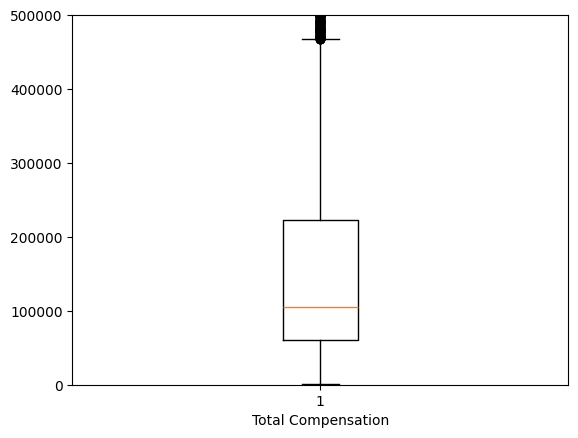

In [9]:
# your code goes here
df1 = """

SELECT CompTotal
FROM main
WHERE CompTotal IS NOT NULL
"""

df1 = pd.read_sql_query(df1, conn)

df1['CompTotal'] = pd.to_numeric(df1['CompTotal'], errors='coerce')
df1 = df1.dropna(subset=['CompTotal'])
#df1['CompTotal'] = df1['CompTotal'] / 100

df1 = df1[(df1['CompTotal'] > 1e3) & (df1['CompTotal'] < 1e7)]

plt.boxplot(df1['CompTotal'])
plt.xlabel('Total Compensation')
plt.ylim(0, 500000)
plt.show()

**2. Box Plot of Age (converted to numeric values)**


Convert the `Age` column into numerical values and visualize the distribution.


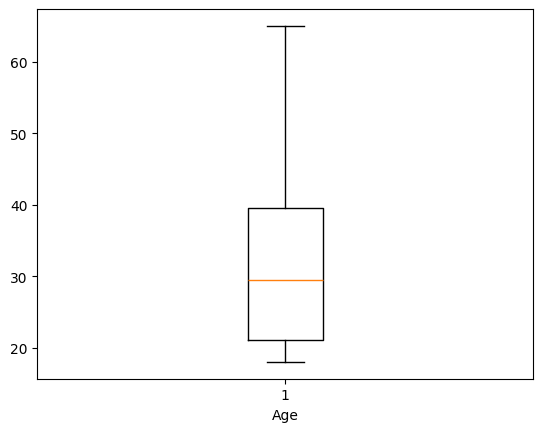

0
[18.  39.5 49.5 21.  29.5 59.5 65. ]


In [10]:
# your code goes here
df2 = """
SELECT Age
FROM main
WHERE Age IS NOT NULL
"""

df2 = pd.read_sql_query(df2, conn)

age_mapping = {
    '25-34 years old': (25+34)/2,
    '35-44 years old': (35+44)/2,
    '18-24 years old': (18+24)/2,
    '45-54 years old': (45+54)/2,
    '55-64 years old': (55+64)/2,
    'Under 18 years old': 18,
    '65 years or older': 65 }

    
df2['AgeGroup'] = df2['Age'].map(age_mapping)
df2['AgeGroup'] = df2['AgeGroup'].astype('float')
mean_age = df2['AgeGroup'].median()
df2['AgeGroup'] = df2['AgeGroup'].fillna(mean_age)

plt.boxplot(df2['AgeGroup'])
plt.xlabel('Age')
plt.show()
print(df2['AgeGroup'].isna().sum())
print(df2['AgeGroup'].unique())

### Task 2: Visualizing Relationships in Data


**1. Box Plot of `CompTotal` Grouped by Age Groups:**


Visualize the distribution of compensation across different age groups.


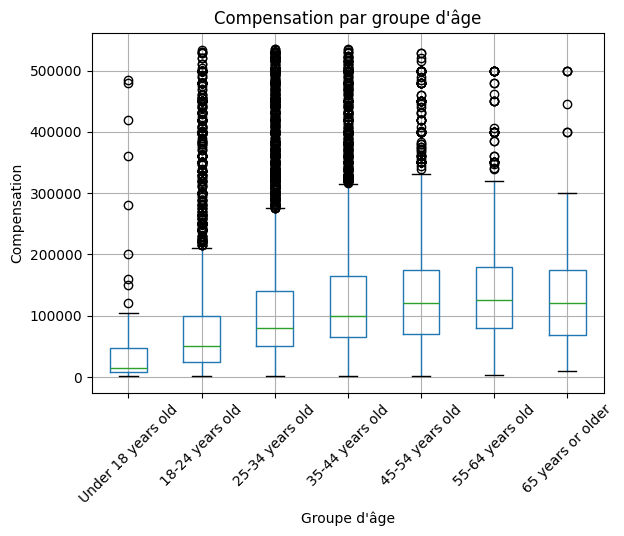

In [11]:
# your code goes here
df3 = """
SELECT Age, CompTotal
FROM main
WHERE Age IS NOT NULL AND CompTotal IS NOT NULL AND Age != 'Prefer not to say'
"""

df3 = pd.read_sql_query(df3, conn)

age_order = [
    'Under 18 years old', '18-24 years old', '25-34 years old',
    '35-44 years old', '45-54 years old', '55-64 years old', '65 years or older']

df3['Age'] = pd.Categorical(df3['Age'], categories=age_order, ordered=True)

Q25 = df3['CompTotal'].quantile(0.25)
Q75 = df3['CompTotal'].quantile(0.75)
IQR = Q75 - Q25

lower_bound = Q25 - 1.5 * IQR
upper_bound = Q75 + 1.5 * IQR

outliers = df3[(df3['CompTotal'] < lower_bound) | (df3['CompTotal'] > upper_bound)]

df3['CompTotal'] = pd.to_numeric(df3['CompTotal'], errors='coerce')

df3 = df3.drop(outliers.index)

df3 = df3.dropna(subset=['CompTotal'])
#df3['CompTotal'] = df3['CompTotal'] / 100

df3 = df3[(df3['CompTotal'] > 1e3) & (df3['CompTotal'] < 1e7)]

df3.boxplot(column='CompTotal', by='Age', rot=45)
plt.title('Compensation par groupe d\'âge')
plt.suptitle('') 
plt.xlabel('Groupe d\'âge')
plt.ylabel('Compensation')
plt.show()

**2. Box Plot of `CompTotal` Grouped by Job Satisfaction (`JobSatPoints_6`):**


Examine how compensation varies based on job satisfaction levels.


/tmp/ipykernel_411/2016535047.py:25: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df4 = df4.groupby('JobSatPoints_6', group_keys=False).apply(remove_outliers_iqr)


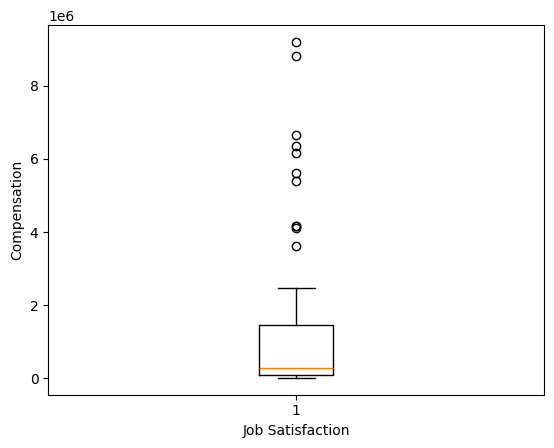

In [12]:
# your code goes here
df4 = """
SELECT JobSatPoints_6, CompTotal
FROM main
WHERE JobSatPoints_6 IS NOT NULL AND CompTotal IS NOT NULL
"""

df4 = pd.read_sql_query(df4, conn)

def remove_outliers_iqr(group):
    Q1 = group['CompTotal'].quantile(0.25)
    Q3 = group['CompTotal'].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return group[(group['CompTotal'] >= lower_bound) & (group['CompTotal'] <= upper_bound)]

df4['CompTotal'] = pd.to_numeric(df4['CompTotal'], errors='coerce')

df4 = df4.groupby('JobSatPoints_6')['CompTotal'].mean().reset_index().round(2)

df4 = df4.dropna(subset=['CompTotal'])
df4 = df4[(df4['CompTotal'] > 1e3) & (df4['CompTotal'] < 1e7)]

df4 = df4.groupby('JobSatPoints_6', group_keys=False).apply(remove_outliers_iqr)

plt.boxplot(df4['CompTotal'])
plt.xlabel('Job Satisfaction')
plt.ylabel('Compensation')
plt.show()

### Task 3: Visualizing the Composition of Data


**1. Box Plot of `ConvertedCompYearly` for the Top 5 Developer Types:**


Analyze compensation across the top 5 developer roles.


/tmp/ipykernel_411/4242048957.py:29: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df5 = df5.groupby('DevType', group_keys=False).apply(remove_outliers_iqr)
/tmp/ipykernel_411/4242048957.py:30: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df5 = df5.groupby('ConvertedCompYearly', group_keys = False).apply(remove_outliers_iqr)


<Figure size 2000x600 with 0 Axes>

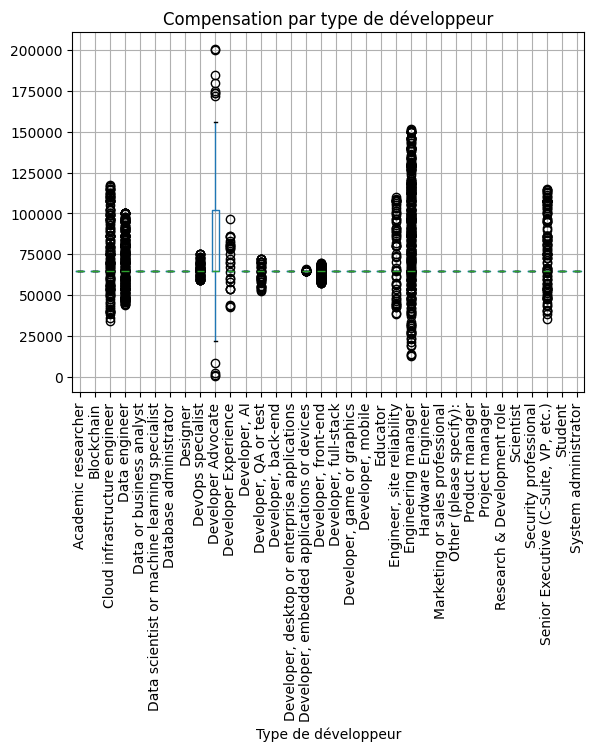

In [14]:
# your code goes here
df5 = """
SELECT ConvertedCompYearly, DevType
FROM main
"""
df5 = pd.read_sql_query(df5, conn)

def fill_with_mode(df5, DevType):
    mode_val = df5['DevType'].mode()[0]
    df5['DevType'] = df5['DevType'].fillna(mode_val)

for col in ['DevType']:
    fill_with_mode(df5, conn)

median_CCY = df5['ConvertedCompYearly'].median()
df5['ConvertedCompYearly'] = df5['ConvertedCompYearly'].fillna(median_CCY)

df5['ConvertedCompYearly'] = pd.to_numeric(df5['ConvertedCompYearly'], errors='coerce')
df5['ConvertedCompYearly'] = df5['ConvertedCompYearly'].astype('float')

def remove_outliers_iqr(group):
    Q1 = group['ConvertedCompYearly'].quantile(0.25)
    Q3 = group['ConvertedCompYearly'].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return group[(group['ConvertedCompYearly'] >= lower_bound) & (group['ConvertedCompYearly'] <= upper_bound)]

df5 = df5.groupby('DevType', group_keys=False).apply(remove_outliers_iqr)
df5 = df5.groupby('ConvertedCompYearly', group_keys = False).apply(remove_outliers_iqr)


plt.figure(figsize=(20, 6))
df5.boxplot(column='ConvertedCompYearly', by='DevType', rot=90)
plt.title('Compensation par type de développeur')
plt.suptitle('')
plt.xlabel('Type de développeur')
plt.show()

**2. Box Plot of `CompTotal` for the Top 5 Countries:**


Analyze compensation across respondents from the top 5 countries.


/tmp/ipykernel_411/1515433762.py:28: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df5 = df5.groupby('DevType', group_keys = False).apply(remove_outliers_iqr)
/tmp/ipykernel_411/1515433762.py:29: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df5 = df5.groupby('ConvertedCompYearly', group_keys = False).apply(remove_outliers_iqr)


<Figure size 2000x600 with 0 Axes>

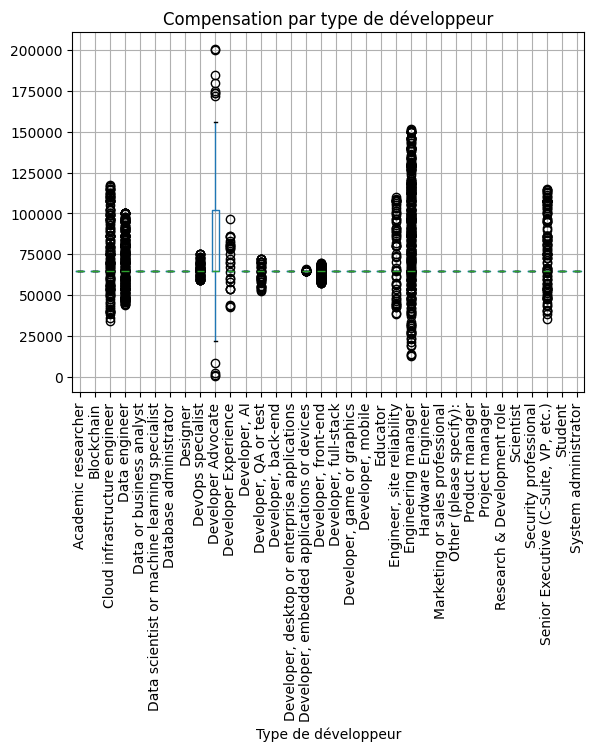

In [15]:
# your code goes here
df5 = """
SELECT ConvertedCompYearly, DevType
FROM main
"""
df5 = pd.read_sql_query(df5, conn)

def fill_with_mode(df5, DevType):
    mode_val = df5['DevType'].mode()[0]
    df5['DevType'] = df5['DevType'].fillna(mode_val)

for col in ['DevType']:
    fill_with_mode(df5, conn)

median_CCY = df5['ConvertedCompYearly'].median()
df5['ConvertedCompYearly'] = df5['ConvertedCompYearly'].fillna(median_CCY)

df5['ConvertedCompYearly'] = pd.to_numeric(df5['ConvertedCompYearly'], errors='coerce')

def remove_outliers_iqr(group):
    Q1 = group['ConvertedCompYearly'].quantile(0.25)
    Q3 = group['ConvertedCompYearly'].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return group[(group['ConvertedCompYearly'] >= lower_bound) & (group['ConvertedCompYearly'] <= upper_bound)]

df5 = df5.groupby('DevType', group_keys = False).apply(remove_outliers_iqr)
df5 = df5.groupby('ConvertedCompYearly', group_keys = False).apply(remove_outliers_iqr)


plt.figure(figsize=(20, 6))
df5.boxplot(column='ConvertedCompYearly', by='DevType', rot=90)
plt.title('Compensation par type de développeur')
plt.suptitle('')
plt.xlabel('Type de développeur')
plt.show()

### Task 4: Visualizing Comparison of Data


**1. Box Plot of CompTotal Across Employment Types:**


Analyze compensation for different employment types.


/tmp/ipykernel_411/500311171.py:22: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df6 = df6.groupby('Employment', group_keys=False).apply(remove_outliers_iqr)
/tmp/ipykernel_411/500311171.py:23: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df6 = df6.groupby('CompTotal', group_keys = False).apply(remove_outliers_iqr)


<Figure size 2800x1000 with 0 Axes>

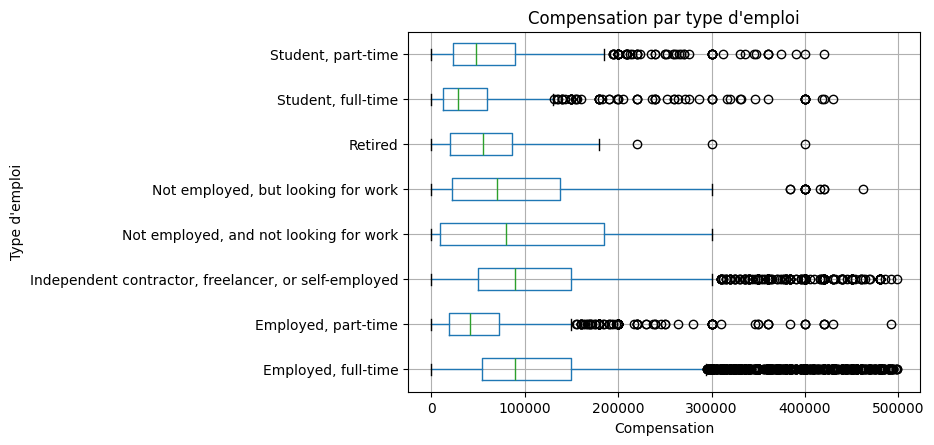

In [16]:
# your code goes here
df6 = """
SELECT Employment, CompTotal
FROM main
WHERE Employment IS NOT NULL AND CompTotal IS NOT NULL
"""
df6 = pd.read_sql_query(df6, conn)

df6['EmpList'] = df6['Employment'].str.split(';').apply(lambda lst: [s.strip() for s in lst])
df6 = df6.explode('EmpList')

df6['CompTotal'] = pd.to_numeric(df6['CompTotal'], errors='coerce')

def remove_outliers_iqr(group):
    Q1 = group['CompTotal'].quantile(0.25)
    Q3 = group['CompTotal'].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return group[(group['CompTotal'] >= lower_bound) & (group['CompTotal'] <= upper_bound)]

df6 = df6.groupby('Employment', group_keys=False).apply(remove_outliers_iqr)
df6 = df6.groupby('CompTotal', group_keys = False).apply(remove_outliers_iqr)


df6 = df6.drop(index = 0)
df6 = df6.drop(columns= 'Employment')

df6 = df6.rename(columns={'EmpList': 'Employment'})

df6 = df6[(df6['CompTotal'] > 0) & (df6['CompTotal'] < 500000)]

plt.figure(figsize=(28, 10))
df6.boxplot(column='CompTotal', by='Employment', rot=0, vert = False)
plt.title('Compensation par type d\'emploi')
plt.suptitle('')
plt.ylabel('Type d\'emploi')
plt.xlabel('Compensation')
plt.xticks(rotation = 0, fontsize = 10)
plt.show()

**2. Box Plot of `YearsCodePro` by Job Satisfaction (`JobSatPoints_6`):**


Examine the distribution of professional coding years by job satisfaction levels.


In [ ]:
# your code goes here

### Final Step: Close the Database Connection


After completing the lab, close the connection to the SQLite database:


In [ ]:
conn.close()

## Summary


In this lab, you used box plots to visualize various aspects of the dataset, focusing on:

- Visualize distributions of compensation and age.

- Explore relationships between compensation, job satisfaction, and professional coding experience.

- Analyze data composition across developer roles and countries.

- Compare compensation across employment types and satisfaction levels.

Box plots provided clear insights into the spread, outliers, and central tendencies of various features in the dataset.


## Authors:
Ayushi Jain


### Other Contributors:
- Rav Ahuja
- Lakshmi Holla
- Malika


<!--## Change Log
|Date (YYYY-MM-DD)|Version|Changed By|Change Description|
|-|-|-|-|               
|2024-10-07|1.2|Madhusudan Moole|Reviewed and updated lab|                                                                                      
|2024-10-06|1.0|Raghul Ramesh|Created lab|-->


Copyright © IBM Corporation. All rights reserved.
